In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import  train_test_split
import copy
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score

In [2]:
failures = pd.read_csv('../data/model_data/failures.csv',sep=',')
components = failures['Component'].unique()

In [3]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'../data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['Turbine_ID'] = encoder.fit_transform(['Turbine_ID']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('Timestamp')

In [4]:
class_target_name = "Failure (Target)"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['Component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [5]:
model_name = "xgb"

In [6]:
for component in components:

    with open("./model/{}_{}.pickle".format(model_name, component), "rb") as f:
        globals()[f"{model_name}_{component}"] = pickle.load(f)

In [7]:
def train_run(X, y, X_valid, y_valid, model):
    clf = model
    clf.fit(X, y)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred, average="weighted")
    precision_train = precision_score(y, y_train_pred, average="weighted")
    recall_train = recall_score(y, y_train_pred, average="weighted")
    f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    precision = precision_score(y_valid, y_valid_pred, average="weighted")
    recall = recall_score(y_valid, y_valid_pred, average="weighted")

    scores = {
        "f1_train": f1_train,
        "precision_train": precision_train,
        "recall_train": recall_train,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

    return scores

In [8]:
def train_runs_XGB(X_train, y_train, model):
    clf = ExtraTreesClassifier(n_estimators=50)
    tree_selector = SelectFromModel(clf)
   
    base_estimator = model
    base_estimator.steps.insert(-1, ["selector", tree_selector])
    param_grid = {

        "selector__max_features": Integer(5, 100),
        "{}__max_depth".format(model_name): [10, 20, 40, 80],
        "{}__n_estimators".format(model_name): [50, 100, 200],
        "{}__learning_rate".format(model_name): Real(0.01, 0.2, prior='log-uniform')

    }
    bayes_search = BayesSearchCV(
        estimator=base_estimator,
        search_spaces=param_grid,
        scoring="f1_weighted",
        n_iter=50,
        cv=5,
        verbose=2,
        random_state=0,
        n_jobs=-1
    )

    bayes_search.fit(X_train, y_train)
    results = bayes_search.cv_results_
    best_clf = bayes_search.best_estimator_

    return best_clf, results, param_grid

In [ ]:
for component in components:
    # get the best model
    globals()[f"{component}_best_clf"], globals()[f"{component}_results"], globals()[f"{component}_param_grid"] = train_runs_XGB(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], globals()[f"{model_name}_{component}"])


In [12]:
def plot_feature_performance(results, param_grid):
    fig, ax = plt.subplots()
    max_features_list = [results["params"][i]["selector__max_features"] for i in range(len(results["params"]))]
    scores = [results["mean_test_score"][i] for i in range(len(results["mean_test_score"]))]

    max_features_list, scores = zip(*sorted(zip(max_features_list, scores)))
    ax.plot(max_features_list, scores, marker='o', color='blue', linestyle='-')
    
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("F1 Score")
    ax.set_title("Number of Features vs F1 Score")
    plt.grid(True)
    plt.show()

Graph for component: GEARBOX


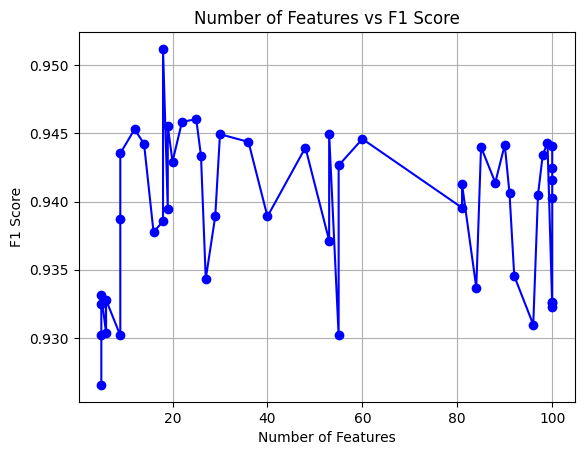

Graph for component: GENERATOR


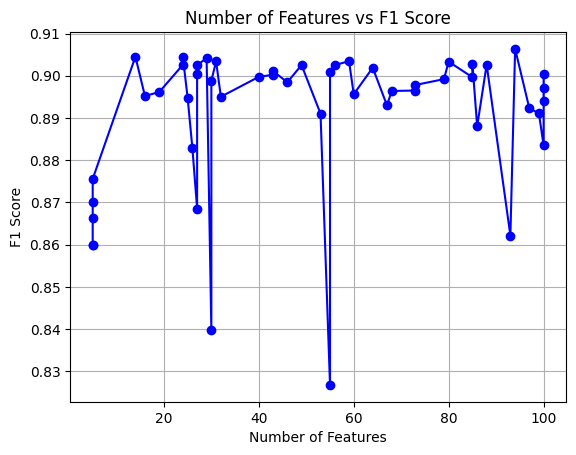

Graph for component: HYDRAULIC_GROUP


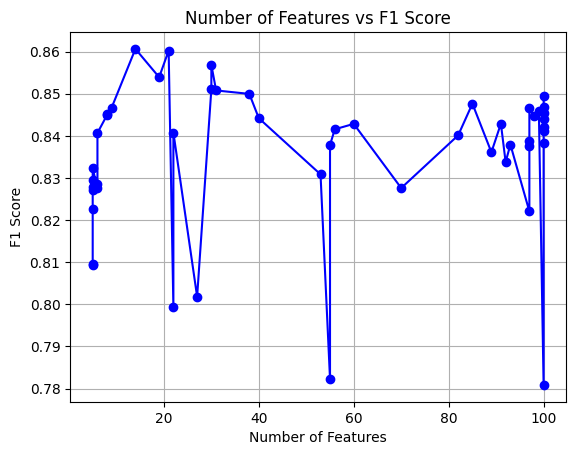

Graph for component: GENERATOR_BEARING


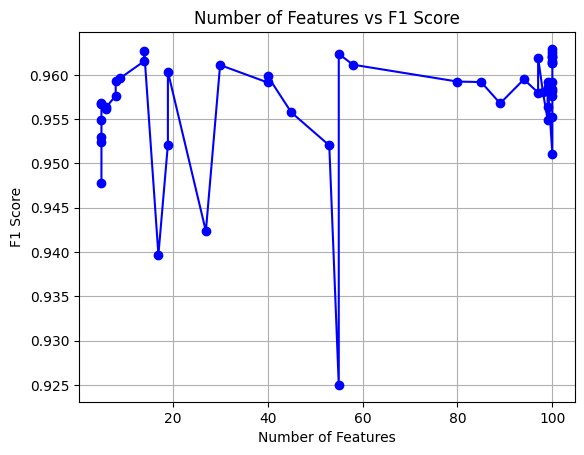

Graph for component: TRANSFORMER


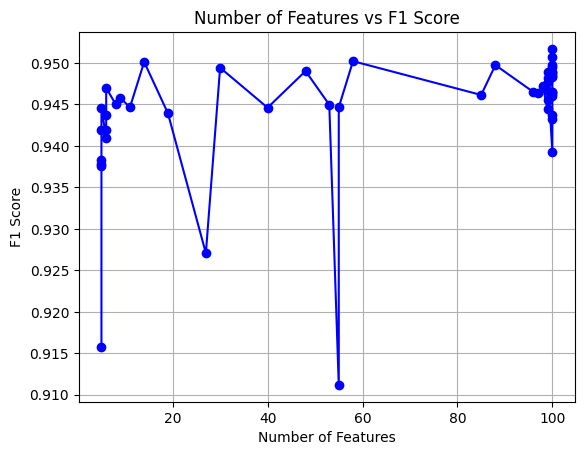

In [14]:
for component in components:
    print("Graph for component: {}".format(component))
    plot_feature_performance(globals()[f"{component}_results"], globals()[f"{component}_param_grid"])

In [15]:
def get_best_features(results):
    best_score = max(results["mean_test_score"])
    best_index = results["mean_test_score"].tolist().index(best_score)
    best_features = results["params"][best_index]["selector__max_features"]
    return best_features

In [17]:
for component in components:
    globals()[f"{component}_best_features"] = get_best_features(globals()[f"{component}_results"])
    print("Best features for component {}: {}".format(component, globals()[f"{component}_best_features"]))

Best features for component GEARBOX: 18
Best features for component GENERATOR: 94
Best features for component HYDRAULIC_GROUP: 14
Best features for component GENERATOR_BEARING: 100
Best features for component TRANSFORMER: 100


In [ ]:
for component in components:
    globals()[f"{component}_scores"] = train_run(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], globals()[f"{component}_X_test"], globals()[f"{component}_y_test"], globals()[f"{component}_best_clf"])
    print("Scores for component {}: {}".format(component, globals()[f"{component}_scores"]))

In [20]:
for component in components:
    
    globals()[f"{component}_y_pred_train"] = globals()[f"{component}_best_clf"].predict(globals()[f"{component}_X_train"])
    globals()[f"{component}_y_pred_test"] = globals()[f"{component}_best_clf"].predict(globals()[f"{component}_X_test"])



In [21]:
# Confusion matrix for each component
for component in components:
    globals()[f"{component}_confusion_matrix_train"] = confusion_matrix(globals()[f"{component}_y_train"], globals()[f"{component}_y_pred_train"])
    globals()[f"{component}_confusion_matrix_test"] = confusion_matrix(globals()[f"{component}_y_test"], globals()[f"{component}_y_pred_test"])

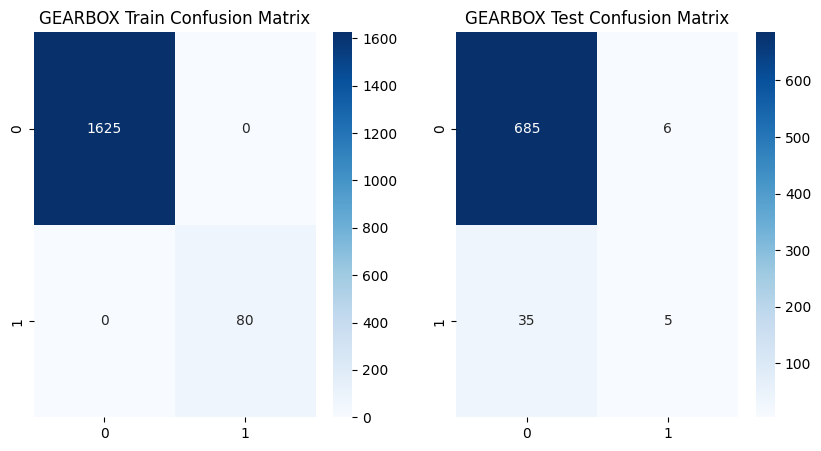

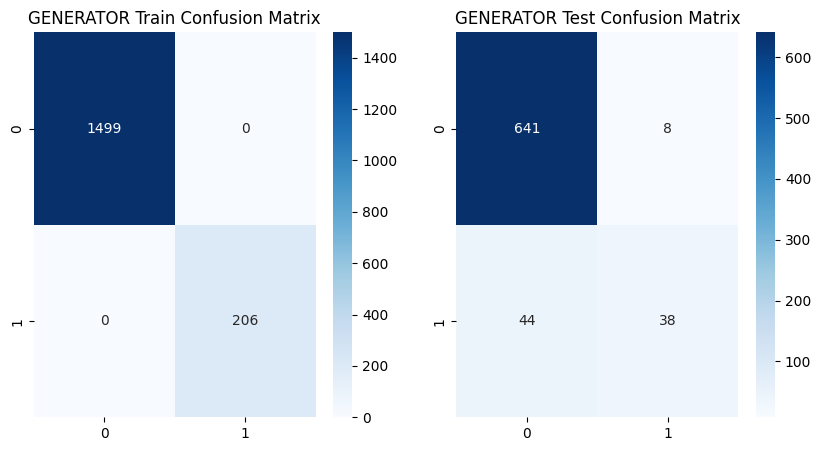

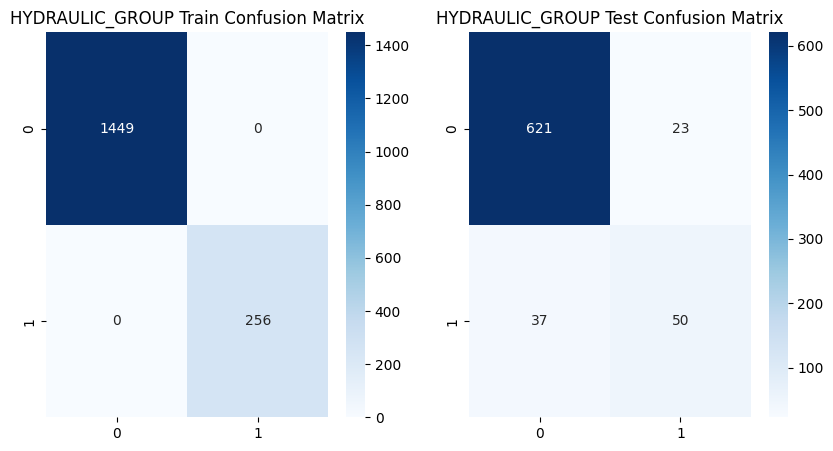

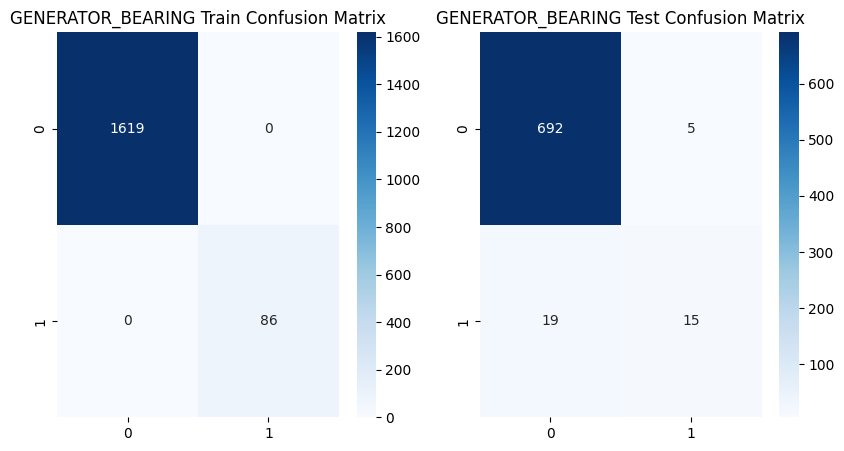

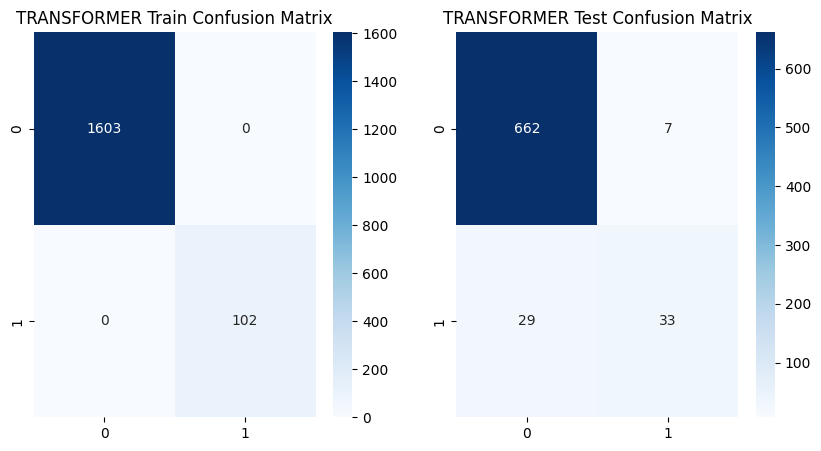

In [22]:
# Plot the confusion matrix
for component in components:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(globals()[f"{component}_confusion_matrix_train"], annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title(f"{component} Train Confusion Matrix")
    sns.heatmap(globals()[f"{component}_confusion_matrix_test"], annot=True, fmt="d", cmap="Blues", ax=ax[1])
    ax[1].set_title(f"{component} Test Confusion Matrix")
    plt.show()

In [23]:
for component in components:

    globals()[f"{component}_train_size_abs"], globals()[f"{component}_train_scores"], globals()[f"{component}_test_scores"] = learning_curve(
        globals()[f"{component}_best_clf"], globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], scoring="f1_weighted"
    )


In [ ]:
my_lc = []
for component in components:
    for train_size, cv_train_scores, cv_test_scores in zip(globals()[f"{component}_train_size_abs"], globals()[f"{component}_train_scores"], globals()[f"{component}_test_scores"]):
            my_lc.append(
        {
            "n": int(train_size),
            "train_score": cv_train_scores.mean(),
            "test_score": cv_test_scores.mean(),
        }
    )
            
my_lc

In [25]:
import pickle
import os

In [26]:
for component in components:
    with open("./model/selected-{}_{}.pickle".format(model_name, component), "wb") as handle:
        handle.write(pickle.dumps(globals()[f"{component}_best_clf"]))